In [27]:
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from preprocess.preprocess import MovieLens

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Classes create for preprocessing and models
from preprocess.preprocess import MovieLens
from models.matrix_factorization import MF
from rec_sys.recsys import RecSys

In [29]:
ml = MovieLens()

In [30]:
n_users, n_items = ml.num_user_item()
model = MF(n_users, n_items, emb_dim=32, init=True)
model.to(device)
print(model)

MF(
  (user_emb): Embedding(610, 32)
  (item_emb): Embedding(9724, 32)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [31]:
train_loader, test_loader = ml.dataset(batch_size=32)

In [32]:
train_losses, val_losses = model.fit(num_epochs=10, train_loader=train_loader, test_loader=test_loader)

epoch 1 loss batch: 2.6728704532632035
epoch 2 loss batch: 0.8499277245006372
epoch 3 loss batch: 0.7009003827471827
epoch 4 loss batch: 0.6300360488591056
epoch 5 loss batch: 0.5700817559655278
epoch 6 loss batch: 0.5222402641809794
epoch 7 loss batch: 0.48879550008053335
epoch 8 loss batch: 0.4655427905679674
epoch 9 loss batch: 0.44887667692861455
epoch 10 loss batch: 0.4369381944450572


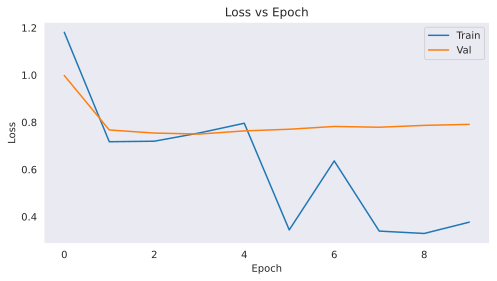

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()


In [34]:
user_emb_min_w = model.user_emb.weight.min().item()
user_emb_max_w = model.user_emb.weight.max().item()
item_emb_min_w = model.item_emb.weight.min().item()
item_emb_max_w = model.item_emb.weight.max().item()

print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
# print(f'Preds min/max: {y_ratings.min().item():0.2f} / {y_hat.max().item():0.2f}')
# print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
# print(preds.detach().cpu().numpy()[:6])
# print(y_ratings.detach().cpu().numpy()[:6])

Emb user min/max w: -0.763 / 1.050
Emb item min/max w: -0.628 / 1.169


In [35]:
model.user_emb.weight.shape, model.item_emb.weight.shape

(torch.Size([610, 32]), torch.Size([9724, 32]))

In [36]:
model.user_emb.weight[1]

tensor([0.3251, 0.5045, 0.4312, 0.3663, 0.2252, 0.1871, 0.2328, 0.5537, 0.0845,
        0.1711, 0.3508, 0.6339, 0.4603, 0.1875, 0.3583, 0.3375, 0.3947, 0.1518,
        0.2339, 0.2703, 0.1948, 0.4635, 0.6455, 0.4814, 0.1350, 0.4042, 0.2439,
        0.2064, 0.5512, 0.1908, 0.3486, 0.2809], grad_fn=<SelectBackward0>)

In [37]:
matrix = ml.get_matrix()
matrix.shape

(610, 9724)

In [38]:
user_ids, item_ids = ml.get_ids()

<class 'numpy.ndarray'>


In [49]:
rec_sys = RecSys(model, matrix, user_ids, item_ids, device)
index, value = rec_sys.make_recommendations(2)


IndexError: The shape of the mask [9724] at index 0 does not match the shape of the indexed tensor [5] at index 0

In [50]:
index, value


([2579, 840, 9600, 2409, 948, 917, 680, 905, 4390, 882],
 array([0.9790714 , 0.97753316, 0.97745866, 0.97686654, 0.97670615,
        0.9759822 , 0.9759319 , 0.97586846, 0.9757331 , 0.9752144 ],
       dtype=float32))

In [51]:
# matrix[matrix.iloc[1]==1].reset_index()

In [52]:
help(torch.topk)

Help on built-in function topk in module torch:

topk(...)
    topk(input, k, dim=None, largest=True, sorted=True, *, out=None) -> (Tensor, LongTensor)
    
    Returns the :attr:`k` largest elements of the given :attr:`input` tensor along
    a given dimension.
    
    If :attr:`dim` is not given, the last dimension of the `input` is chosen.
    
    If :attr:`largest` is ``False`` then the `k` smallest elements are returned.
    
    A namedtuple of `(values, indices)` is returned with the `values` and
    `indices` of the largest `k` elements of each row of the `input` tensor in the
    given dimension `dim`.
    
    The boolean option :attr:`sorted` if ``True``, will make sure that the returned
    `k` elements are themselves sorted
    
    Args:
        input (Tensor): the input tensor.
        k (int): the k in "top-k"
        dim (int, optional): the dimension to sort along
        largest (bool, optional): controls whether to return largest or
               smallest element

In [43]:
user_input = torch.full((len(item_ids),), 2, dtype=torch.long)
item_input = torch.tensor(item_ids, dtype=torch.long)

# Pass inputs through the model
predictions = model(user_input, item_input)

# Apply sigmoid function to predictions if necessary
# predictions = torch.sigmoid(predictions)

# Convert predictions to numpy array
predictions = predictions.detach().cpu().numpy()

predictions

array([2.407902 , 1.8394685, 2.5805097, ..., 1.9264336, 2.2675068,
       1.9119766], dtype=float32)

In [44]:
matrix.iloc[2]

movieId
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9719    0.0
9720    0.0
9721    0.0
9722    0.0
9723    0.0
Name: 2, Length: 9724, dtype: float64

In [46]:
# Example usage:
user_id = 10  # ID of the user for whom you want to get ratings
item_ids = [1, 2, 3, 4, 5]  # IDs of the movies you want to get ratings for
movie_names = {1: "Movie 1", 2: "Movie 2", 3: "Movie 3", 4: "Movie 4", 5: "Movie 5"}  # Example movie names
user_ratings = rec_sys.make_rec(model, user_id, item_ids, movie_names, matrix)
for rating in user_ratings:
    print("Movie:", rating['movie_name'])
    print("Predicted Rating:", rating['predicted_rating'])
    print("Real Rating:", rating['real_rating'])
    print()

AttributeError: 'RecSys' object has no attribute 'make_rec'